In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1.Package & Dependencies Setup

In [2]:
"""Install NSL package"""
!pip install --upgrade neural_structured_learning

     |████████████████████████████████| 122kB 8.0MB/s 


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from neural_structured_learning.tools import graph_utils
import neural_structured_learning as nsl
import tensorflow_addons as tfa
from copy import deepcopy
from sklearn.metrics import multilabel_confusion_matrix
import random
import os
import PIL
import time
import re

tf.keras.backend.clear_session()
print("Version: ", tf.__version__)
print("keras", tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.3.0
keras 2.4.0
Eager mode:  True
GPU is available


In [5]:
from graph_data_processing import GraphDataProcess
from AAE_model import AAE
from Kmeans import KMeans, KMeansModels
from nsl_data_processing import GenerateTrainTestDict, NSLDataFormat
from AD_model_builder import AD_params, ADModelBuilder, AccEarlyStop

In [6]:
''' label definition: NonDemented - 0, VeryMildDemented - 1, MildDemented -2, ModerateDemented -3 '''
label_list = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
root_path = '/content/drive/My Drive/Projects/codes/graph_images_balanced/'
path_list = [f'{root_path}{label}/' for label in label_list]
tfr_list = [f'{root_path}{label}.tfr' for label in label_list]
tfr_rep_list = [f'{root_path}{label}_AAErep.tfr' for label in label_list]

#2.Image & Graph Data Processing

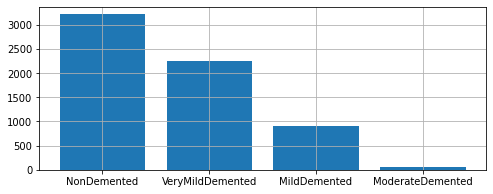

In [ ]:
'''image counts before balancing'''
image_counts={}
for label in label_list: 
    image_counts[f'{label}_image_counts'] = len(os.listdir(f'/content/drive/My Drive/Projects/codes/graph_images/{label}/'))
count_list = list(image_counts.values())
plt.figure(figsize=(8,3))
plt.bar(label_list, count_list)
plt.grid()
plt.show()

In [ ]:
'''balancing images(Note: images in the cloud drive is balanced already, so need to run it)'''
# GraphDataProcess.balance_dataset(root_path=root_path, 
#                                  label_list=label_list, 
#                                  image_size=(208, 176), 
#                                  balance_vision=False)

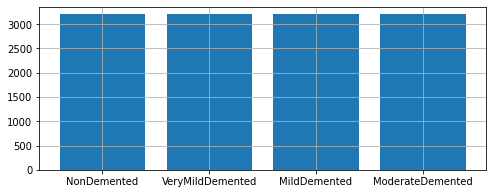

In [ ]:
'''image counts before balancing'''
image_counts={}
for label in label_list: 
    image_counts[f'{label}_image_counts'] = len(os.listdir(f'{root_path}{label}/'))
count_list = list(image_counts.values())
plt.figure(figsize=(8,3))
plt.bar(label_list, count_list)
plt.grid()
plt.show()

In [ ]:
"""generate tfr files(Note: tfr files are generated already, so no need to run this line)"""
# GraphDataProcess.generate_tfr_raw(path_list=path_list, tfr_list=tfr_list) 

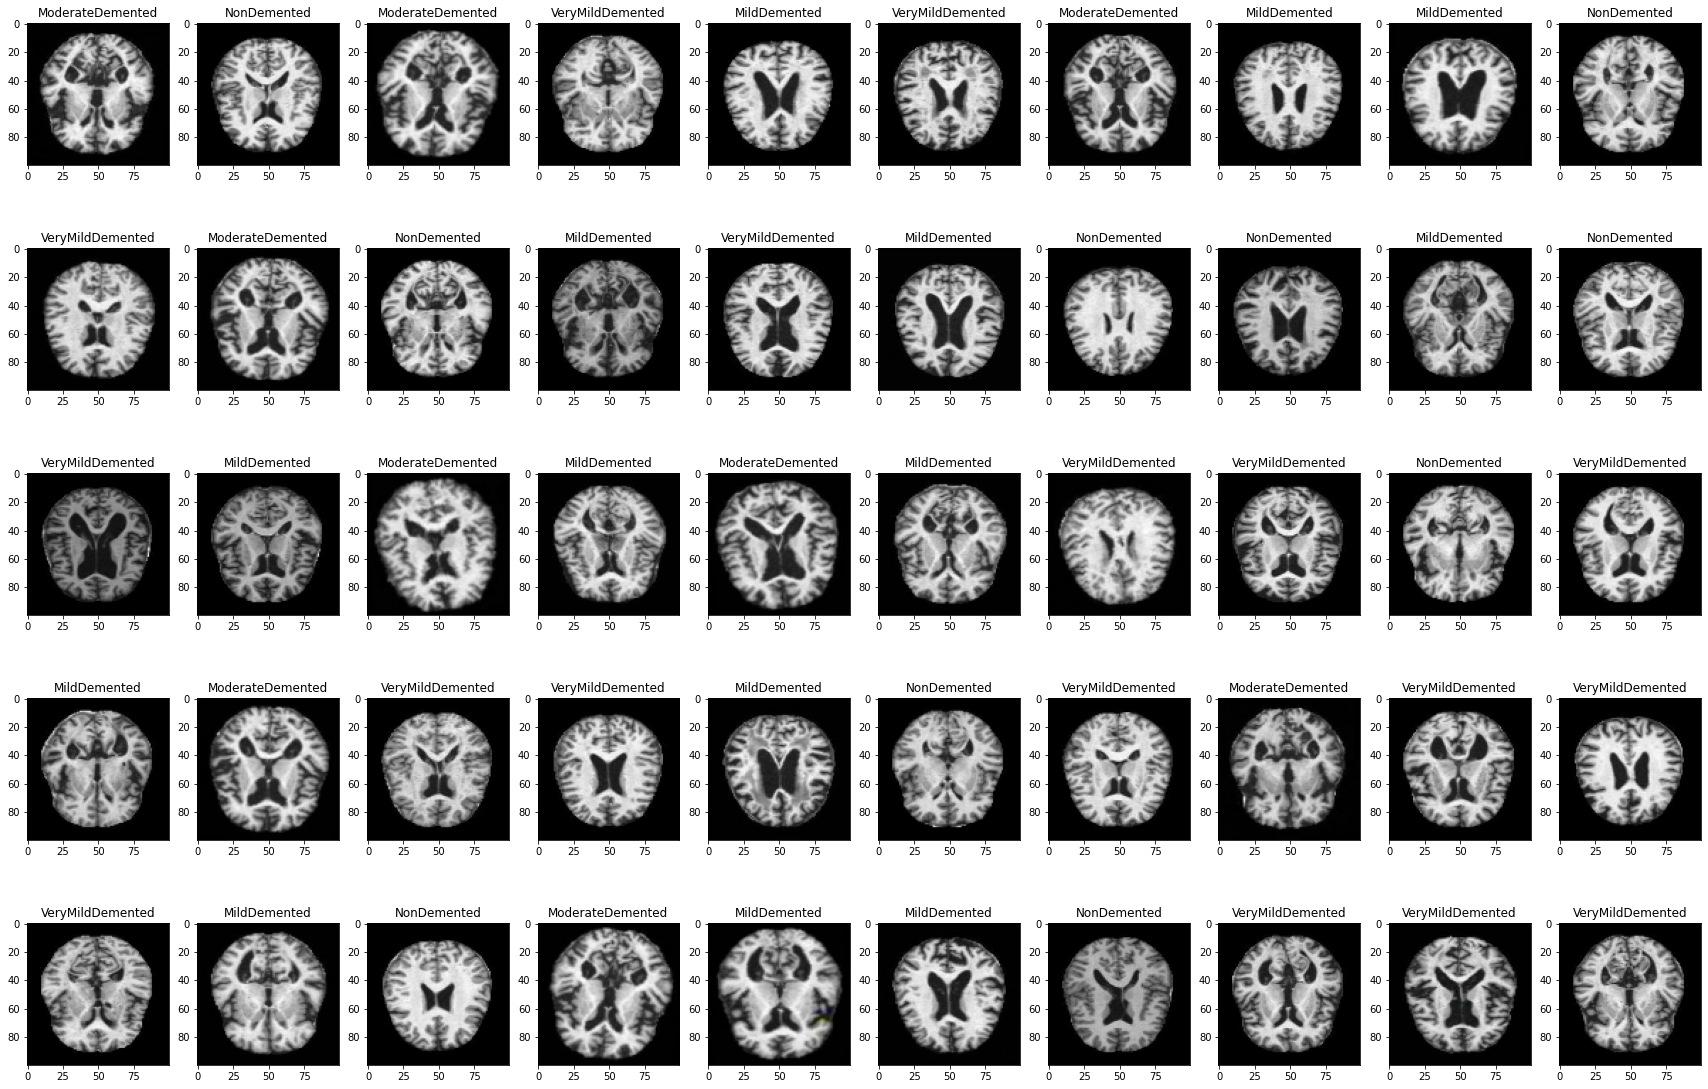

In [ ]:
'''Plot parsed image tensors with size at 100 * 100 * 3'''
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=tfr_list, 
                                                           batch_size=50, 
                                                           size=(100,100),
                                                           channels=3,
                                                           shuffle=True)
dt = iter(image_dataset).get_next()
plt.figure(figsize=(30,20))
for img_index, img_tensor in enumerate(dt['image_tensor']):
    ax = plt.subplot(5, 10, img_index + 1)
    plt.imshow(img_tensor)
    plt.title(label_list[dt['label'].numpy()[img_index]])

# 3. Generate AAE represents for Train MRI Images

In [ ]:
'''Generate AAE represents'''
latent_dim = 128
learning_rate = 0.0005
channels = 3
real_mean = 0
real_std = 1
batch = 1
size=(100, 100)
epochs= 1
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=tfr_list, 
                                                           batch_size=batch, 
                                                           size= size, 
                                                           channels= channels, 
                                                           shuffle=True)
aae = AAE(latent_dim=latent_dim, 
          image_channels=channels,
          aae_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True))
path = '/content/drive/My Drive/Projects/codes/AAE_model_checkpoints_balance/aae_model_checkpoints_balance_colab_WorkFlow_III'
# aae.load_weights(path)                                                    # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run

In [ ]:
# aae.fit(image_dataset=image_dataset,
#         checkpoints_path=path,
#         batch_size=1,
#         real_mean=real_mean,
#         real_std=real_std,
#         epochs=epochs,)                                                   

epoch:  1, epoch_time: 108.67354, total_loss: 2.39788, discriminator_loss: 1.38610, generator_loss: 0.69315, reconstruction_loss: 0.31863


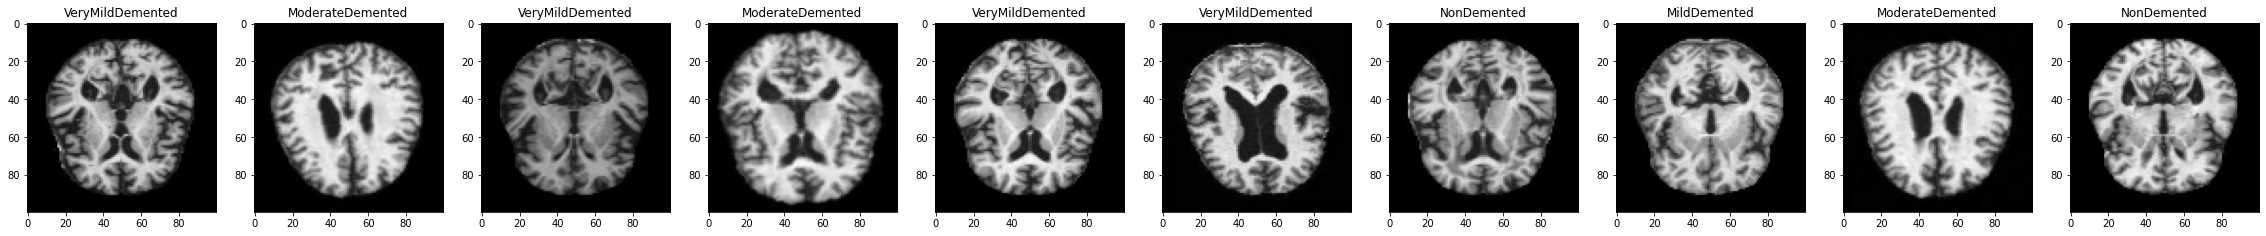

In [ ]:
'''Plot real images vs reconstructed images'''
tfr_list = [f'{root_path}{label}.tfr' for label in label_list]
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=tfr_list, 
                                                           batch_size=10, 
                                                           size=(100,100),
                                                           channels=3,
                                                           shuffle=True)
data = iter(image_dataset).get_next()
plt.figure(figsize=(40,50))
for img_index, img_tensor in enumerate(data['image_tensor']):
    plt.subplot(1, 10, img_index + 1)
    plt.imshow(img_tensor)
    plt.title(label_list[data['label'].numpy()[img_index]])

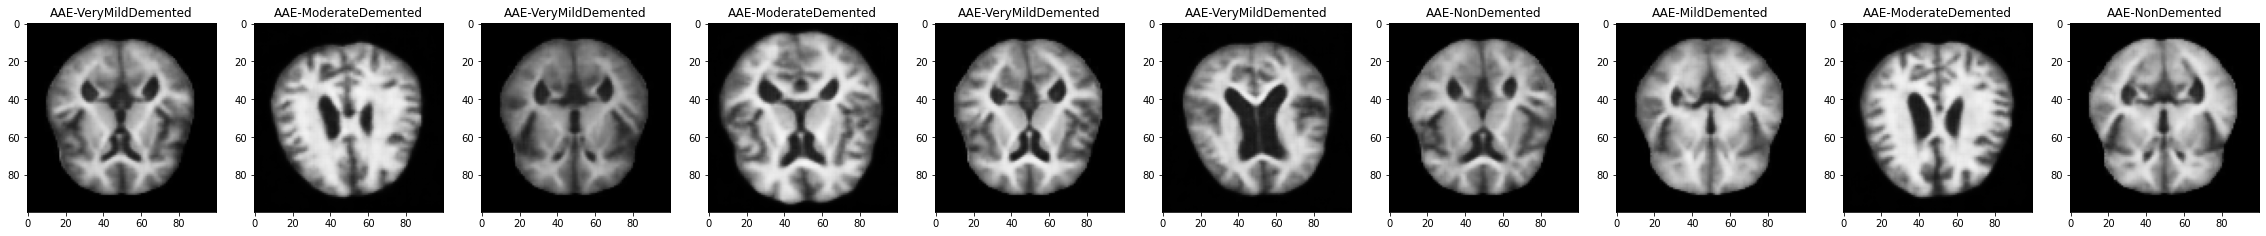

In [ ]:
plt.figure(figsize=(40,50))
for img_index, img_tensor in enumerate(data['image_tensor']):
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    _m, _l, rep = aae.encoder(img_tensor)
    img_new = aae.decoder(rep)
    img_new = tf.squeeze(img_new, axis=0)
    plt.subplot(1, 10, img_index + 1)
    plt.imshow(tf.abs(img_new))
    plt.title('AAE-'+label_list[data['label'].numpy()[img_index]])

In [ ]:
"""generate K_means models for each label data"""
batch= 5000
rep_dim= 128
K_value_list = [10,10, 10, 10] # for both train and test data
epoch= 50
tfr_rep_list = [f'{root_path}{label}_AAErep.tfr' for label in label_list]
Kmeans_model_list = KMeansModels.generate_model_list(path_list = tfr_rep_list, rep_dim=rep_dim, K_list=K_value_list, epoch=epoch, batch=batch)

In [ ]:
'''generate all AD image into one graph with clustering'''
threshold = 0.85
complete_graph = GraphDataProcess.generate_complete_graph_with_cluster_kmeans(tfr_rep_path_list= tfr_rep_list,
                                                                              prefix_list= [0,1,2,3], 
                                                                              model_list= Kmeans_model_list, 
                                                                              represent_dim= 128, 
                                                                              file_output_path= f'{root_path}AD_graph_aae_kmeans.tsv',
                                                                              similarity_threshold=threshold)
complete_graph

In [ ]:
"""count seed node number for each label"""
seed_count={}

for key in complete_graph.keys():
    split_content = key.split('_')[0]
    if 'c' not in split_content: 
        index=int(split_content)
        if index in [0,1,2,3] and (index in seed_count):
            seed_count[index] +=1
        elif index in [0,1,2,3] and (index not in seed_count):
            seed_count[index] =1
print(seed_count)

In [ ]:
'''generate train and test examples from AD images'''
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'
path_list = [f'{root_path}{label}/' for label in label_list]
train_examples, test_examples = GenerateTrainTestDict.get_train_test_dict(path_list=path_list, train_percentage=0.7)
print('train examples: ', len(train_examples.keys()))
print('test examples', len(test_examples.keys()))

In [ ]:
'''merge train examples with the graph (with clusters)'''
train_tfr_path = f'{root_path}train_data.tfr'
graph = nsl.tools.read_tsv_graph(f'{root_path}AD_graph_aae_kmeans.tsv')
max_seed_node_neighbours = 5
nsl_train= NSLDataFormat(seed_dict_examples=train_examples, 
                         rem_dict_examples=test_examples, 
                         graph=graph, 
                         max_nbrs=max_seed_node_neighbours)
nsl_train.generate_node_nbrs_tfr(output_file_path=train_tfr_path)

'''parse train_graph_examples with clusters'''
parsed_image_size=(208,176)
parsed_image_channel=3
batch=1
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[train_tfr_path],
                                                   batch_size=batch,
                                                   max_neighbor_number=max_seed_node_neighbours,
                                                   image_size=parsed_image_size,
                                                   image_channels=parsed_image_channel,
                                                   shuffle=True)
data_sample = iter(train_image_dataset).get_next()
'''plot parsed train_graph examples with clusters'''
label =  tf.argmax(data_sample[1], axis=0)
sample = data_sample[0]
img_index=0
plt.figure(figsize=(30,10))
for key, value in sample.items():
    if key.split('_')[-1]=='tensor':
        plt.subplot(1,max_seed_node_neighbours+1,img_index + 1)
        img_tensor = tf.reshape(value, shape=value.shape[1:])
        plt.imshow(img_tensor)
        plt.title(f'{label_list[label.numpy()[0]]}:{key}')
        img_index +=1

In [ ]:
'''merge test examples with the graph clusters'''
test_tfr_path = f'{root_path}test_data.tfr'
graph = nsl.tools.read_tsv_graph(f'{root_path}AD_graph_aae_kmeans.tsv')
max_seed_node_neighbours = 5

nsl_train= NSLDataFormat(seed_dict_examples=test_examples, 
                         rem_dict_examples=train_examples, 
                         graph=graph, 
                         max_nbrs=max_seed_node_neighbours)
nsl_train.generate_node_nbrs_tfr(output_file_path=test_tfr_path)

'''parse test_graph_examples with clusters'''
parsed_image_size=(208,176)
parsed_image_channel=3
batch=1
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[test_tfr_path],
                                                         batch_size=batch,
                                                         max_neighbor_number=max_seed_node_neighbours,
                                                         image_size=parsed_image_size,
                                                         image_channels=parsed_image_channel,
                                                         shuffle=True)
data_sample = iter(test_image_dataset).get_next()
'''plot parsed train_graph examples with clusters'''
label =  tf.argmax(data_sample[1], axis=0)
sample = data_sample[0]
img_index=0
plt.figure(figsize=(30,10))
for key, value in sample.items():
    if key.split('_')[-1]=='tensor':
        plt.subplot(1,max_seed_node_neighbours+1,img_index + 1)
        img_tensor = tf.reshape(value, shape=value.shape[1:])
        plt.imshow(img_tensor)
        plt.title(f'{label_list[label.numpy()[0]]}:{key}')
        img_index +=1

#3.VGG19 & VGG19-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)s
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

# '''load data with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=params.batch_size,
                                                        max_neighbor_number=params.max_seed_nbr,
                                                        image_size=params.image_size,
                                                        image_channels=params.image_channels,
                                                        shuffle=True)

## 3.1 VGG19 Base Model Training
### val_acc: 0.9077, val_auc: 0.9887, val_f1_score: 0.9072

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/VGG19_model_checkpoints/vgg19_weights_colab'
params.early_stop_base_line=0.90
params.train_epoch=50
"""build a base_model and restore weights from last training"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',  tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# base_model.load_weights(params.checkpoint_path)                               # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
80142336/80134624 [==============================] - 1s 0us/step
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
batch_norm

In [ ]:
'''train base model'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, 
                                                          mode='max',save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpoints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     71/Unknown - 17s 238ms/step - loss: 0.1673 - accuracy: 0.9341 - auc: 0.9947
Epoch 00001: val_accuracy improved from -inf to 0.89302, saving model to /content/drive/My Drive/Projects/codes/VGG19_model_checkpoints/vgg19_weights_colab
71/71 [==============================] - 25s 347ms/step - loss: 0.1673 - accuracy: 0.9341 - auc: 0.9947 - val_loss: 0.2692 - val_accuracy: 0.8930 - val_auc: 0.9869
Epoch 2/50
70/71 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9282 - auc: 0.9933
Epoch 00002: val_accuracy did not improve from 0.89302
71/71 [==============================] - 24s 344ms/step - loss: 0.1872 - accuracy: 0.9281 - auc: 0.9932 - val_loss: 0.2768 - val_accuracy: 0.8914 - val_auc: 0.9860
Epoch 3/50
70/71 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9238 - auc: 0.9930
Epoch 00003: val_accuracy did not improve from 0.89302
71/71 [==============================] - 24s 340ms/step - loss: 0.1935 - accuracy: 0.9237 - auc: 0.9929 - val

In [ ]:
'''evaluate the base model'''
base_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 7s 248ms/step - loss: 0.2368 - accuracy: 0.9077 - auc: 0.9887 - f1_score: 0.9072


[0.23682084679603577,
 0.9076641201972961,
 0.988690972328186,
 0.9072490334510803]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=3900,
                                                        max_neighbor_number=5,
                                                        image_size=(100,100),
                                                        image_channels=3,
                                                        shuffle=True)
data, data_label = iter(test_image_dataset).get_next()

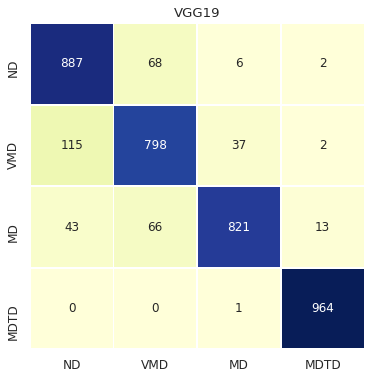

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "VGG19")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(base_model,data, data_label)

TN: [2702 2737 2836 2841]
TP: [887 798 821 964]
FN: [ 76 154 122   1]
FP: [158 134  44  17]
Acc: [0.93879152 0.92466649 0.9565786  0.99529166]
ER(Error rate): [0.06120848 0.07533351 0.0434214  0.00470834]
Recall(TP rate): [0.92107996 0.83823529 0.87062566 0.99896373]
Specialty(TN rate): [0.94475524 0.95332637 0.98472222 0.99405178]
Fall Out(FP rate): [0.05524476 0.04667363 0.01527778 0.00594822]
Miss Rate(FN rate): [0.07892004 0.16176471 0.12937434 0.00103627]


## 3.2 VGG19-NSL Model Training
### val_acc: 0.9103, val_auc: 0.9898, val_f1_score: 0.9111

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_91'
params.early_stop_base_line=0.91
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
"""build a base_model"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()
"""build a NSL model on top of the base model and retore weights from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.checkpoint_path)                          # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
''' setup early stoping and checkpoints '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''NSL model training'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default vgg19 not includes top and has imagenet weights. It is not trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names function based on the VGG19 layer name as follows
 ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4']
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_16 (Flatten)         (None, 4608)              0         
_____________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     71/Unknown - 57s 799ms/step - loss: 0.1726 - accuracy: 0.9362 - auc: 0.9948 - f1_score: 0.9358 - scaled_graph_loss: 0.0075

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.91054, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_91
71/71 [==============================] - 65s 909ms/step - loss: 0.1726 - accuracy: 0.9362 - auc: 0.9948 - f1_score: 0.9358 - scaled_graph_loss: 0.0075 - val_loss: 0.2254 - val_accuracy: 0.9105 - val_auc: 0.9901 - val_f1_score: 0.9282
Epoch 00002: early stopping


In [ ]:
graph_reg_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 6s 210ms/step - loss: 0.2254 - accuracy: 0.9105 - auc: 0.9901 - f1_score: 0.9102


[0.22542521357536316,
 0.9105414748191833,
 0.9901122450828552,
 0.910239577293396]

## 3.3 VGG19-NSL 5th block tunning
### val_acc: 0.9472, val_auc: 0.9951, val_f1_score: 0.9461

In [ ]:
'''define params'''
params.learning_rate = 0.0000004
params.checkpoint_restore_path = '/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_94'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_94'
params.early_stop_base_line=0.94
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base model'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').setup_VGG19_by_layer_names(trainable_layers=['block5_conv1', 
                                                                                                                                           'block5_conv2', 
                                                                                                                                           'block5_conv3', 
                                                                                                                                           'block5_conv4']).get_ADModel()
"""restore NSL model from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type, 
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.checkpoint_restore_path)                  # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run

Note: default vgg19 not includes top and has imagenet weights. It is not trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names function based on the VGG19 layer name as follows
 ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4']
trainable layer:  block5_conv1
trainable layer:  block5_conv2
trainable layer:  block5_conv3
trainable layer:  block5_conv4
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
______________________________________________

In [ ]:
"""set up training checkpoint and earlystop callbacks"""
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch')
callback_earlystop = AccEarlyStop(val_acc_base = params.early_stop_base_line)
"""NSL model training"""
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs= params.train_epoch,
                                        verbose=1)

In [ ]:
"""evaluate tuned model"""
graph_reg_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 7s 248ms/step - loss: 0.1528 - accuracy: 0.9472 - auc: 0.9951 - f1_score: 0.9461


[0.15282970666885376,
 0.9471619129180908,
 0.9951168298721313,
 0.9461125731468201]

## 3.4 VGG19-NSL 1,2,3,4th block tunning
### val_acc: 0.9503, val_auc: 0.9954, val_f1_score: 0.9507


In [ ]:
'''define params'''
params.learning_rate =0.0000001
params.checkpoint_restore_path = '/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_94'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_95'
params.early_stop_base_line=0.95
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').setup_VGG19_by_layer_names(trainable_layers=['block1_conv2', 
                                                                                                                                           'block2_conv2', 
                                                                                                                                           'block3_conv4', 
                                                                                                                                           'block4_conv4', 
                                                                                                                                           'block5_conv4']).get_ADModel()
"""build NSL model with base_model and restore weights from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix="NL_nbr_",
                                                     neighbor_weight_suffix='_weight',
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= 0.1,
                                                     distance_type= nsl.configs.DistanceType.COSINE, 
                                                     sum_over_axis=-1 )
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.checkpoint_restore_path)                  # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
"""set up training checkpoint and earlystop callbacks"""
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch')
callback_earlystop = AccEarlyStop(val_acc_base = params.early_stop_base_line)
"""NSL model training"""
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default vgg19 not includes top and has imagenet weights. It is not trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names function based on the VGG19 layer name as follows
 ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4']
trainable layer:  block1_conv2
trainable layer:  block2_conv2
trainable layer:  block3_conv4
trainable layer:  block4_conv4
trainable layer:  block5_conv4
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
______________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     71/Unknown - 59s 826ms/step - loss: 0.0585 - accuracy: 0.9867 - auc: 0.9997 - f1_score: 0.9865 - scaled_graph_loss: 0.0035

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.83573, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_95
71/71 [==============================] - 66s 936ms/step - loss: 0.0585 - accuracy: 0.9867 - auc: 0.9997 - f1_score: 0.9865 - scaled_graph_loss: 0.0035 - val_loss: 0.5567 - val_accuracy: 0.8357 - val_auc: 0.9623 - val_f1_score: 0.9416
Epoch 2/100
70/71 [============================>.] - ETA: 0s - loss: 0.5659 - accuracy: 0.8248 - auc: 0.9553 - f1_score: 0.8235 - scaled_graph_loss: 0.0094
Epoch 00002: val_accuracy improved from 0.83573 to 0.84672, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_95
71/71 [==============================] - 64s 906ms/step - loss: 0.5660 - accuracy: 0.8247 - auc: 0.9553 - f1_score: 0.8235 - scaled_graph_loss: 0.0096 - val_loss: 0.3660 - val_accuracy: 0.8467 - val_auc: 0.9766 - val_f1_score: 0.8480
Epoch 3/100
70/71 [===================

In [ ]:
"""evaluate tuned model"""
graph_reg_model.evaluate(test_image_dataset)

30/30 [==============================] - 6s 197ms/step - loss: 0.1385 - accuracy: 0.9503 - auc: 0.9954 - f1_score: 0.9507


[0.13852135837078094, 0.9503008127212524, 0.99541836977005, 0.9507079720497131]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=3900,
                                                        max_neighbor_number=5,
                                                        image_size=(100,100),
                                                        image_channels=3,
                                                        shuffle=True)
data, data_label = iter(test_image_dataset).get_next()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


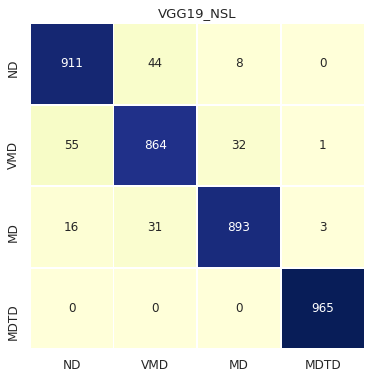

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, "VGG19_NSL")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(graph_reg_model, data, data_label)

TN: [2789 2796 2840 2854]
TP: [911 864 893 965]
FN: [52 88 50  0]
FP: [71 75 40  4]
Acc: [0.96782631 0.95736333 0.97645828 0.9989537 ]
ER(Error rate): [0.03217369 0.04263667 0.02354172 0.0010463 ]
Recall(TP rate): [0.94600208 0.90756303 0.94697773 1.        ]
Specialty(TN rate): [0.97517483 0.9738767  0.98611111 0.99860042]
Fall Out(FP rate): [0.02482517 0.0261233  0.01388889 0.00139958]
Miss Rate(FN rate): [0.05399792 0.09243697 0.05302227 0.        ]


#4.DenseNet121 & DenseNet121-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

# '''load data with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=params.batch_size,
                                                        max_neighbor_number=params.max_seed_nbr,
                                                        image_size=params.image_size,
                                                        image_channels=params.image_channels,
                                                        shuffle=True)

## 4.1 DenseNet Base Model Training
### val_acc: 0.9152, val_auc: 0.9906, val_f1_score: 0.91498

In [ ]:
'''define params'''
params.learning_rate=0.01
params.checkpoint_restore_path='/content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_91'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_91'
params.early_stop_base_line=0.91
params.train_epoch=100

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# base_model.load_weights(params.checkpoint_restore_path)                       # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run

'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "DenseNet121_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________

In [ ]:
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     70/Unknown - 20s 289ms/step - loss: 0.2892 - accuracy: 0.8853 - auc: 0.9845
Epoch 00001: val_accuracy improved from -inf to 0.90950, saving model to /content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_91
71/71 [==============================] - 32s 453ms/step - loss: 0.2891 - accuracy: 0.8853 - auc: 0.9845 - val_loss: 0.2449 - val_accuracy: 0.9095 - val_auc: 0.9897
Epoch 2/50
70/71 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8868 - auc: 0.9853
Epoch 00002: val_accuracy improved from 0.90950 to 0.91211, saving model to /content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_91
71/71 [==============================] - 30s 424ms/step - loss: 0.2818 - accuracy: 0.8868 - auc: 0.9852 - val_loss: 0.2394 - val_accuracy: 0.9121 - val_auc: 0.9905
Epoch 3/50
70/71 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.8749 - auc: 0.9842
Epoch 00003: val_accuracy did not improve 

In [ ]:
'''evaluate base model'''
base_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 7s 227ms/step - loss: 0.2332 - accuracy: 0.9171 - auc: 0.9910 - f1_score: 0.9150


[0.2331920564174652, 0.917080819606781, 0.9909543991088867, 0.9149808287620544]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=3900,
                                                        max_neighbor_number=5,
                                                        image_size=(100,100),
                                                        image_channels=3,
                                                        shuffle=True)
data, data_label = iter(test_image_dataset).get_next()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


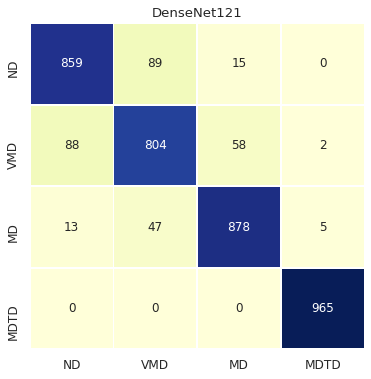

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "DenseNet121")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(base_model, data, data_label)

TN: [2759 2735 2807 2851]
TP: [859 804 878 965]
FN: [104 148  65   0]
FP: [101 136  73   7]
Acc: [0.94637719 0.92571279 0.96390269 0.99816898]
ER(Error rate): [0.05362281 0.07428721 0.03609731 0.00183102]
Recall(TP rate): [0.89200415 0.84453782 0.93107105 1.        ]
Specialty(TN rate): [0.96468531 0.95262975 0.97465278 0.99755073]
Fall Out(FP rate): [0.03531469 0.04737025 0.02534722 0.00244927]
Miss Rate(FN rate): [0.10799585 0.15546218 0.06892895 0.        ]


## 4.2 DenseNet_NSL Model Training
### val_acc: 0.9207, val_auc: 0.9914, val_f1_score: 0.9191



In [ ]:
'''define params'''
params.learning_rate=0.001
params.restore_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_92'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_92'
params.early_stop_base_line=0.92
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.restore_path)                             # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     71/Unknown - 66s 926ms/step - loss: 0.2879 - accuracy: 0.8852 - auc: 0.9858 - scaled_graph_loss: 0.0115

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.91656, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_92
71/71 [==============================] - 79s 1s/step - loss: 0.2879 - accuracy: 0.8852 - auc: 0.9858 - scaled_graph_loss: 0.0115 - val_loss: 0.2351 - val_accuracy: 0.9166 - val_auc: 0.9907
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8812 - auc: 0.9844 - scaled_graph_loss: 0.0122
Epoch 00002: val_accuracy improved from 0.91656 to 0.91734, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_92
71/71 [==============================] - 75s 1s/step - loss: 0.3007 - accuracy: 0.8812 - auc: 0.9844 - scaled_graph_loss: 0.0122 - val_loss: 0.2335 - val_accuracy: 0.9173 - val_auc: 0.9909
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8820 - auc: 0.9844 - scaled_graph_loss: 0.012

In [ ]:
graph_reg_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 6s 215ms/step - loss: 0.2293 - accuracy: 0.9207 - auc: 0.9914 - f1_score: 0.9191


[0.22929221391677856,
 0.9207428693771362,
 0.9913583397865295,
 0.9190904498100281]

## 4.3 DenseNet_NSL top 20 layers and bottom 50 laysers tuning
### val_acc: 0.9521, val_auc: 0.9944, val_f1_score: 0.9515

In [ ]:
'''redefine hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

'''reload data with samll batch at 64'''
graph = nsl.tools.read_tsv_graph(params.graph_path)
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=params.batch_size,
                                                        max_neighbor_number=params.max_seed_nbr,
                                                        image_size=params.image_size,
                                                        image_channels=params.image_channels,
                                                        shuffle=True)

In [ ]:
params.learning_rate=0.0001
params.restore_path='/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_95'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_95'
params.early_stop_base_line=0.95
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=10, middle_layers=None, bottom_layers=50).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
'''restore the model from last training'''
# graph_reg_model.load_weights(params.restore_path)                             # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is a fully trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
29089792/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
_______________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


    141/Unknown - 209s 1s/step - loss: 1.2030 - accuracy: 0.6264 - auc: 0.8620 - f1_score: 0.6152 - scaled_graph_loss: 0.0161

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.67748, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_95
141/141 [==============================] - 227s 2s/step - loss: 1.2030 - accuracy: 0.6264 - auc: 0.8620 - f1_score: 0.6152 - scaled_graph_loss: 0.0161 - val_loss: 0.6769 - val_accuracy: 0.6775 - val_auc: 0.9161 - val_f1_score: 0.6323
Epoch 2/100
141/141 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.7038 - auc: 0.9221 - f1_score: 0.6905 - scaled_graph_loss: 0.0099
Epoch 00002: val_accuracy improved from 0.67748 to 0.74287, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_95
141/141 [==============================] - 216s 2s/step - loss: 0.6675 - accuracy: 0.7038 - auc: 0.9221 - f1_score: 0.6905 - scaled_graph_loss: 0.0099 - val_loss: 0.5460 - val_accuracy: 0.7429 - val_auc: 0.9442 - val_f1_score: 0.7324
Epoch 3/10

## 4.4 DenseNet_NSL top 20 layers, middle 30 layers and bottom 20 laysers tuning
### val_acc: 0.9804, val_auc: 0.9978, val_f1_score: 0.9804

In [ ]:
'''redefine hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

'''reload data with samll batch at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=params.batch_size,
                                                        max_neighbor_number=params.max_seed_nbr,
                                                        image_size=params.image_size,
                                                        image_channels=params.image_channels,
                                                        shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.000005
params.restore_path='/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_97'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_98'
params.early_stop_base_line=0.98
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=20, middle_layers=[185, 215], bottom_layers=20).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
'''restore the model from last training'''
# graph_reg_model.load_weights(params.restore_path)                              # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is a fully trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 106, 106, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_6[0][0]           
________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


    141/Unknown - 61s 430ms/step - loss: 0.0456 - accuracy: 0.9861 - auc: 0.9995 - f1_score: 0.9860 - scaled_graph_loss: 0.0021

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.93278, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_98
141/141 [==============================] - 74s 522ms/step - loss: 0.0456 - accuracy: 0.9861 - auc: 0.9995 - f1_score: 0.9860 - scaled_graph_loss: 0.0021 - val_loss: 0.2025 - val_accuracy: 0.9328 - val_auc: 0.9897 - val_f1_score: 0.9701
Epoch 2/100
141/141 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9853 - auc: 0.9995 - f1_score: 0.9854 - scaled_graph_loss: 0.0024
Epoch 00002: val_accuracy improved from 0.93278 to 0.94638, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_98
141/141 [==============================] - 70s 493ms/step - loss: 0.0485 - accuracy: 0.9853 - auc: 0.9995 - f1_score: 0.9854 - scaled_graph_loss: 0.0024 - val_loss: 0.1524 - val_accuracy: 0.9464 - val_auc: 0.9948 - val_f1_score: 0.9470
Epoch 

In [ ]:
'''evalute the test model'''
graph_reg_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


60/60 [==============================] - 7s 119ms/step - loss: 0.0688 - accuracy: 0.9804 - auc: 0.9978 - f1_score: 0.9804


[0.06876537203788757,
 0.9803819060325623,
 0.9978272914886475,
 0.9803767204284668]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=3900,
                                                        max_neighbor_number=5,
                                                        image_size=(100,100),
                                                        image_channels=3,
                                                        shuffle=True)
data, data_label = iter(test_image_dataset).get_next()

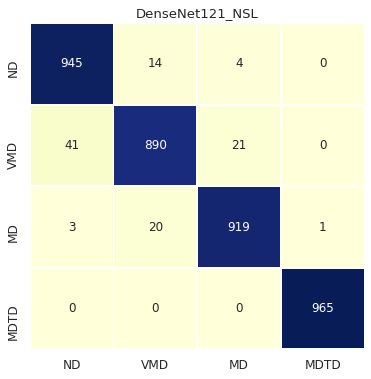

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, title="DenseNet121_NSL")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=graph_reg_model, data=data, data_label=data_label)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


TN: [2816 2837 2855 2857]
TP: [945 890 919 965]
FN: [18 62 24  0]
FP: [44 34 25  1]
Acc: [0.98378237 0.97488883 0.98718284 0.99973843]
ER(Error rate): [0.01621763 0.02511117 0.01281716 0.00026157]
Recall(TP rate): [0.98130841 0.93487395 0.97454931 1.        ]
Specialty(TN rate): [0.98461538 0.98815744 0.99131944 0.9996501 ]
Fall Out(FP rate): [0.01538462 0.01184256 0.00868056 0.0003499 ]
Miss Rate(FN rate): [0.01869159 0.06512605 0.02545069 0.        ]


#5.Xception & Xception-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

'''load data with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=params.batch_size,
                                                        max_neighbor_number=params.max_seed_nbr,
                                                        image_size=params.image_size,
                                                        image_channels=params.image_channels,
                                                        shuffle=True)

##5.1 Xception Base Model Training
### val_acc: 0.840, val_auc: 0.974, val_f1_score: 0.837

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_restore_path='/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_90'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_90'
params.early_stop_base_line=0.90
params.train_epoch=10

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# base_model.load_weights(params.checkpoint_restore_path)                       # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
______________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     71/Unknown - 13s 189ms/step - loss: 0.3561 - accuracy: 0.8533 - auc: 0.9767 - f1_score: 0.8518
Epoch 00001: val_accuracy improved from -inf to 0.83024, saving model to /content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_90
71/71 [==============================] - 25s 351ms/step - loss: 0.3561 - accuracy: 0.8533 - auc: 0.9767 - f1_score: 0.8518 - val_loss: 0.4042 - val_accuracy: 0.8302 - val_auc: 0.9702 - val_f1_score: 0.8288
Epoch 2/10
70/71 [============================>.] - ETA: 0s - loss: 0.3649 - accuracy: 0.8467 - auc: 0.9753 - f1_score: 0.8468
Epoch 00002: val_accuracy improved from 0.83024 to 0.84044, saving model to /content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_90
71/71 [==============================] - 21s 296ms/step - loss: 0.3648 - accuracy: 0.8467 - auc: 0.9753 - f1_score: 0.8468 - val_loss: 0.3740 - val_accuracy: 0.8404 - val_auc: 0.9742 - val_f1_score: 0.8372
Epoch 3/10
70/71 [==========================

In [ ]:
"""evaluate base_model"""
base_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 7s 229ms/step - loss: 0.3740 - accuracy: 0.8404 - auc: 0.9742 - f1_score: 0.8372


[0.3739946186542511,
 0.8404394388198853,
 0.9741536378860474,
 0.8371719121932983]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


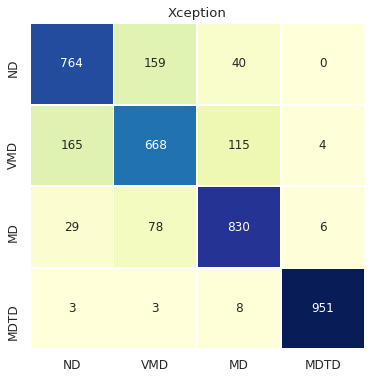

In [ ]:
'''confusion matrix & acc for each label'''
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=3900,
                                                        max_neighbor_number=5,
                                                        image_size=(100,100),
                                                        image_channels=3,
                                                        shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
ADModelBuilder.plot_confusion_mat(model=base_model, data=data, data_label=data_label, title="Xception", figsize=(6,6))

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=base_model, data=data, data_label=data_label)

TN: [2663 2631 2717 2848]
TP: [764 668 830 951]
FN: [199 284 113  14]
FP: [197 240 163  10]
Acc: [0.89641643 0.86293487 0.92780539 0.99372221]
ER(Error rate): [0.10358357 0.13706513 0.07219461 0.00627779]
Recall(TP rate): [0.7933541  0.70168067 0.88016967 0.98549223]
Specialty(TN rate): [0.93111888 0.91640543 0.94340278 0.99650105]
Fall Out(FP rate): [0.06888112 0.08359457 0.05659722 0.00349895]
Miss Rate(FN rate): [0.2066459  0.29831933 0.11983033 0.01450777]


##5.2 Xception_NSL Model Training
### val_acc: 0.957,val_auc: 0.993,val_f1_score:0.957

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

'''load data with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=params.batch_size,
                                                        max_neighbor_number=params.max_seed_nbr,
                                                        image_size=params.image_size,
                                                        image_channels=params.image_channels,
                                                        shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.00005
params.restore_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_94'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95'
params.early_stop_base_line=0.95
params.train_epoch=50
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=10, middle_layers=None, bottom_layers=5).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.restore_path)                             # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      2/Unknown - 1s 295ms/step - loss: 0.0232 - accuracy: 1.0000 - auc: 1.0000 - f1_score: 1.0000 - scaled_graph_loss: 0.0014WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2210s vs `on_train_batch_end` time: 0.3680s). Check your callbacks.
    141/Unknown - 82s 582ms/step - loss: 0.0215 - accuracy: 0.9953 - auc: 1.0000 - f1_score: 0.9954 - scaled_graph_loss: 0.0021

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.93958, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95
141/141 [==============================] - 91s 645ms/step - loss: 0.0215 - accuracy: 0.9953 - auc: 1.0000 - f1_score: 0.9954 - scaled_graph_loss: 0.0021 - val_loss: 0.1884 - val_accuracy: 0.9396 - val_auc: 0.9918 - val_f1_score: 0.9787
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9731 - auc: 0.9983 - f1_score: 0.9732 - scaled_graph_loss: 0.0042
Epoch 00002: val_accuracy improved from 0.93958 to 0.94533, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95
141/141 [==============================] - 89s 632ms/step - loss: 0.0844 - accuracy: 0.9731 - auc: 0.9983 - f1_score: 0.9732 - scaled_graph_loss: 0.0042 - val_loss: 0.1693 - val_accuracy: 0.9453 - val_auc: 0.9930 - val_f1_score: 0.9453
Epoch 3/50
141/141 [=========================

##5.3 Xception_NSL Model top 10 and bottom 5 layers tunning
### val_acc: 0.972, val_auc: 0.996, val_f1_score: 0.971

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

'''load data with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=params.batch_size,
                                                        max_neighbor_number=params.max_seed_nbr,
                                                        image_size=params.image_size,
                                                        image_channels=params.image_channels,
                                                        shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.00001
params.restore_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_96'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_97'
params.early_stop_base_line=0.97
params.train_epoch=50
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=10, middle_layers=None, bottom_layers=5).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.restore_path)                               # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


    141/Unknown - 124s 877ms/step - loss: 0.0232 - accuracy: 0.9945 - auc: 0.9997 - f1_score: 0.9944 - scaled_graph_loss: 0.0021

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.95056, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_97
141/141 [==============================] - 135s 957ms/step - loss: 0.0232 - accuracy: 0.9945 - auc: 0.9997 - f1_score: 0.9944 - scaled_graph_loss: 0.0021 - val_loss: 0.1870 - val_accuracy: 0.9506 - val_auc: 0.9913 - val_f1_score: 0.9812
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9848 - auc: 0.9987 - f1_score: 0.9847 - scaled_graph_loss: 0.0029
Epoch 00002: val_accuracy improved from 0.95056 to 0.95972, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_97
141/141 [==============================] - 134s 948ms/step - loss: 0.0567 - accuracy: 0.9848 - auc: 0.9987 - f1_score: 0.9847 - scaled_graph_loss: 0.0029 - val_loss: 0.1353 - val_accuracy: 0.9597 - val_auc: 0.9939 - val_f1_score: 0.9600
Epoch 3/50
141/141 [=======================

In [ ]:
'''evaluate the model'''
graph_reg_model.evaluate(test_image_dataset)

60/60 [==============================] - 7s 109ms/step - loss: 0.1078 - accuracy: 0.9715 - auc: 0.9958 - f1_score: 0.9715


[0.10780985653400421,
 0.971488356590271,
 0.9958271384239197,
 0.9714585542678833]

In [ ]:
'''confusion matrix & acc for each label'''
test_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.test_tfr_path],
                                                        batch_size=3900,
                                                        max_neighbor_number=5,
                                                        image_size=(100,100),
                                                        image_channels=3,
                                                        shuffle=True)
data, data_label = iter(test_image_dataset).get_next()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


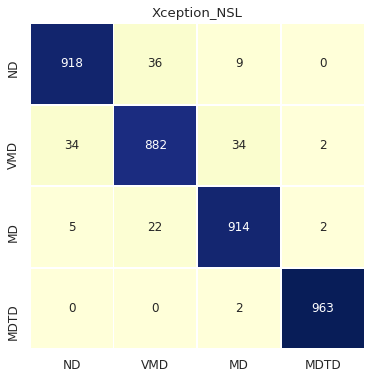

In [ ]:
ADModelBuilder.plot_confusion_mat(model=graph_reg_model, data=data, data_label=data_label, title="Xception_NSL", figsize=(6,6))

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=graph_reg_model, data=data, data_label=data_label)

TN: [2821 2813 2835 2854]
TP: [918 882 914 963]
FN: [45 70 29  2]
FP: [39 58 45  4]
Acc: [0.97802773 0.96651844 0.98064347 0.99843055]
ER(Error rate): [0.02197227 0.03348156 0.01935653 0.00156945]
Recall(TP rate): [0.95327103 0.92647059 0.96924708 0.99792746]
Specialty(TN rate): [0.98636364 0.97979798 0.984375   0.99860042]
Fall Out(FP rate): [0.01363636 0.02020202 0.015625   0.00139958]
Miss Rate(FN rate): [0.04672897 0.07352941 0.03075292 0.00207254]
